# AI Community @ Семинар № 9, весна 2018
## Вариационный автокодировщик (Variational Autoencoder)

In [2]:
import numpy as np
import itertools as it
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
import torch.utils.data as data_utils

from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython.display import clear_output

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
GPU_IDX = 7

Сегодня будем работать с частью датасета Labelled Faces in the Wild, в которой выбраны все лица с видом спереди.

In [4]:
# https://github.com/yandexdataschool/YSDA_deeplearning17/blob/master/Seminar8/lfw_dataset.py
from lfw_dataset import fetch_lfw_dataset
data, attrs = fetch_lfw_dataset()

In [5]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


In [6]:
X_train = np.float32(X_train)
X_train = X_train / 255
X_val = np.float32(X_val)
X_val = X_val / 255

In [7]:
def unflatten(image, h=image_h, w=image_w):
    return image.reshape((h, w, 3))

In [159]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    '''Utility function for plotting a number of images at once.'''
    plt.figure(figsize=(1.3 * n_col, 1.5 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.99, hspace=.15)
    for i in range(n_row * n_col):
        image = unflatten(images[i], h, w)
        image = np.clip(image, 0, 1)
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(image, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

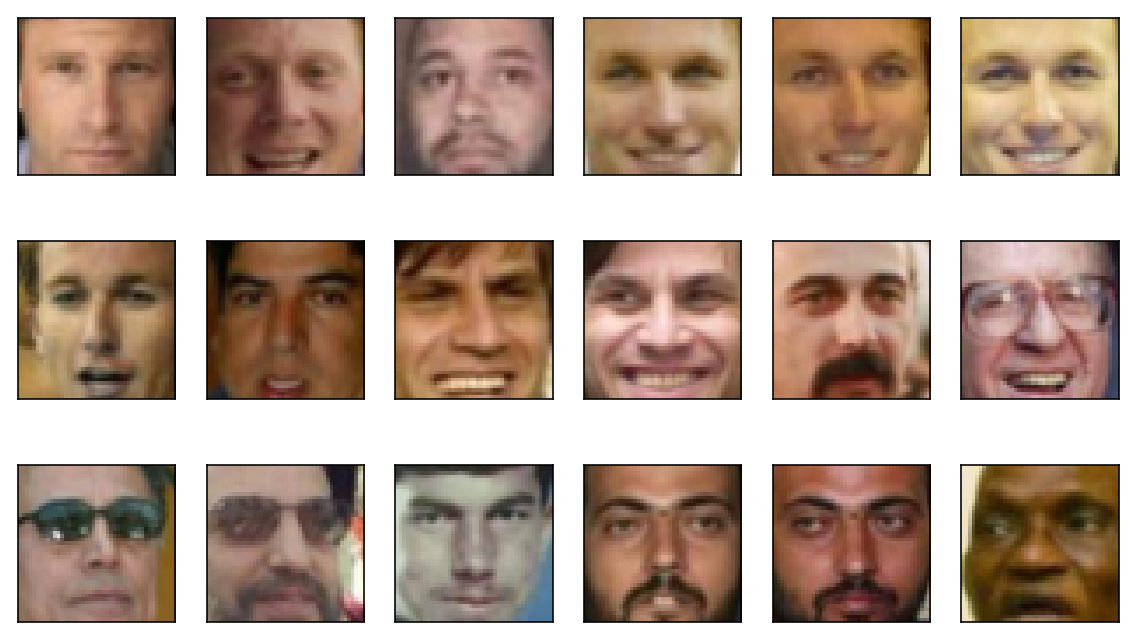

In [160]:
plot_gallery(X_train, image_h, image_w)

Обернем датасет в специальный формат для PyTorch.

In [10]:
# Для корректности требуется передать в TensorDataset псевдометки
train = data_utils.TensorDataset(torch.Tensor(X_train),
                                 torch.zeros(X_train.shape[0],))
train_loader = data_utils.DataLoader(train, batch_size=128, shuffle=True, num_workers=1)

val = data_utils.TensorDataset(torch.Tensor(X_val),
                               torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False, num_workers=1)

Определим вариационный автокодировщик.

In [11]:
hidden_size = 200

In [12]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(3 * image_h * image_w, 512)
        # Reparametrization Trick
        self.fc2_mu = nn.Linear(512, hidden_size)
        self.fc2_logsigma = nn.Linear(512, hidden_size)
        
        self.fc3 = nn.Linear(hidden_size, 512)
        # Reparametrization Trick — декодер тоже будет моделировать распределение
        self.fc4_mu = nn.Linear(512, 3 * image_h * image_w)
        self.fc4_logsigma = nn.Linear(512, 3 * image_h * image_w)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        h1 = self.fc1(x)
        h1 = self.relu(h1)
        
        mu, logsigma = self.fc2_mu(h1), self.fc2_logsigma(h1)
        return mu, logsigma
    
    def decode(self, z):
        h3 = self.fc3(z)
        h3 = self.relu(h3)
        
        mu, logsigma = self.fc4_mu(h3), self.fc4_logsigma(h3)
        return mu, logsigma
    
    def sampler(self, mu, log_sigma):
        if self.training:
            std = log_sigma.exp()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, latent_samples=1):
        latent_mu, latent_logsigma = self.encode(x)
        z_s = [self.sampler(latent_mu, latent_logsigma)
               for _ in range(latent_samples)]
        return [self.decode(z) for z in z_s], latent_mu, latent_logsigma

Теперь выпишем для него функцию потерь. Нам требуется максимизировать вариационную нижнюю оценку:
$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$
Следовательно, ее и будем использовать как функцию потерь, но со знаком минус.

Напомним формулы для частного случая — моделирования нормальным распределением:
$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{hidden\_size}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{hidden\_size}\log p_{\theta}(x_i|z)=\sum_{i=1}^{hidden\_size} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

In [13]:
def KL_divergence(mu, log_sigma):
    '''Computes KL divergence between normal distribution with parameters `mu` and `sigma` and N(0, 1).'''
    log_sigma_squared = 2 * log_sigma
    sigma_squared = log_sigma_squared.exp()
    return -0.5 * torch.sum(1 + log_sigma_squared - torch.pow(mu, 2) - sigma_squared, dim=1)

def log_likelihood(x, mu, log_sigma):
    '''Computes log-likelihood of normal distribution with parameters `mu` and `sigma`.'''
    return -torch.sum(((mu - x) ** 2) / (2 * (2 * log_sigma).exp())
                      + log_sigma
                      + 0.5 * np.log(2 * np.pi), dim=1)

def loss_vae_expected(x, gen_samples, mu_z, logsigma_z):
    '''Loss function for Variational Autoencoder. Log-likelihood is taken in average.'''
    lower_bound = -KL_divergence(mu_z, logsigma_z) + \
                torch.mean(torch.stack([log_likelihood(x, mu, logsigma)
                                        for mu, logsigma in gen_samples]), dim=0)
    return -torch.mean(lower_bound)

Создаем модель и оптимизатор для нее.

In [20]:
vae = VAE().cuda(GPU_IDX)

optimizer = optim.Adam(vae.parameters())

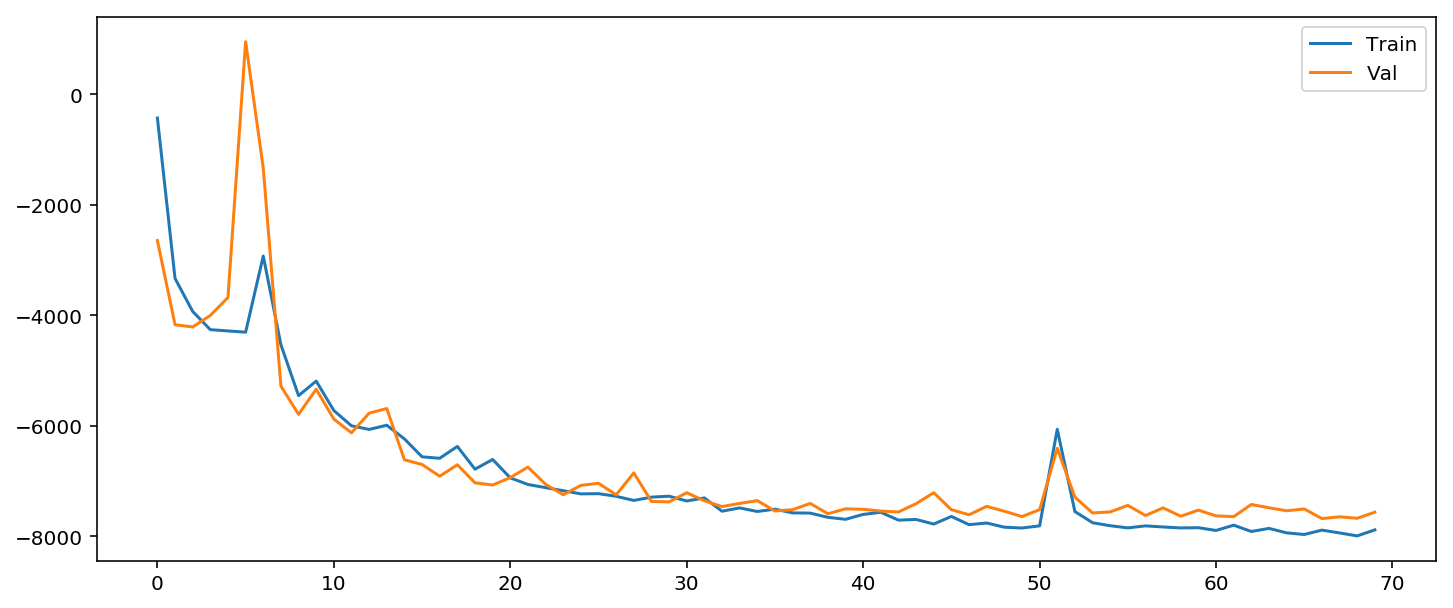

100%|██████████| 70/70 [05:48<00:00,  4.98s/it]


In [21]:
epochs = 70

train_losses, val_losses = [], []
for epoch in tqdm(range(epochs)):    
    total_loss = 0.
    iters = 0
    vae.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        x = Variable(x).cuda(GPU_IDX)
        
        gen_samples, latent_mu, latent_logsigma = vae.forward(x, latent_samples=5)
        loss = loss_vae_expected(x, gen_samples, latent_mu, latent_logsigma)
    
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        iters += 1
    train_losses.append(total_loss.data.cpu().numpy() / iters)
    
    vae.eval()
    total_loss = 0.
    iters = 0
    for x, y in val_loader:
        x = Variable(x).cuda(GPU_IDX)
        
        gen_samples, latent_mu, latent_logsigma = vae.forward(x, latent_samples=1)
        loss = loss_vae_expected(x, gen_samples, latent_mu, latent_logsigma)
        
        total_loss += loss
        iters += 1
    val_losses.append(total_loss.data.cpu().numpy() / iters)
    
    clear_output(wait=True)
    
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.legend()
    plt.show()

Отрисуем выученное автокодировщиком представление на валидации.

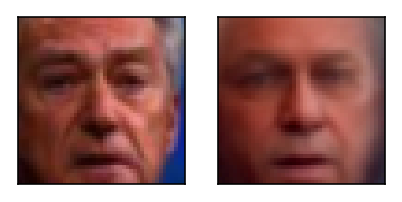

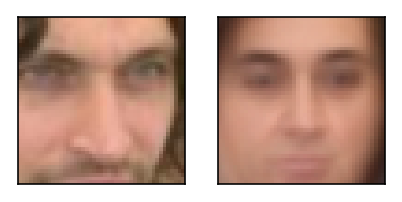

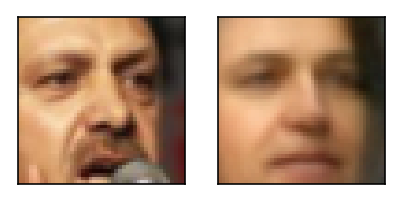

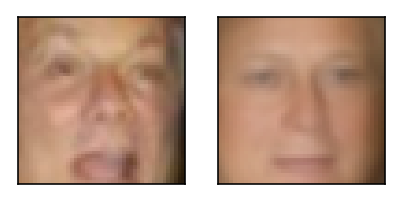

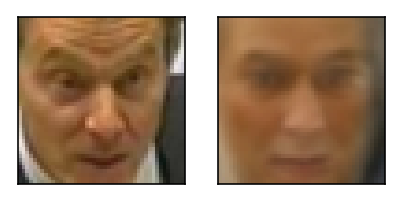

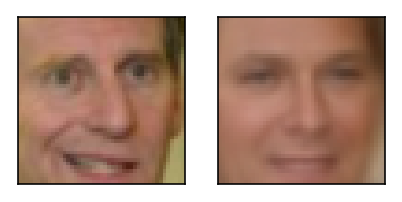

In [162]:
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=True)
for j, data in enumerate(val_loader, 0):
    input = Variable(data[0].cuda(GPU_IDX))
    reconstruction_mu, _, _ = vae.forward(input)
    reconstruction_mu = reconstruction_mu[0][0].data.cpu()
    plot_gallery([input.data.cpu().numpy(), reconstruction_mu.numpy()],
                 image_h, image_w, n_row=1, n_col=2)
    if (j >= 5):
        break

In [57]:
def gaussian_sampler(mu, log_sigma):
    std = log_sigma.exp()
    eps = Variable(std.data.new(std.size()).normal_())
    return eps.mul(std).add_(mu)

def sample_from_latent(mu, log_sigma):
    return gaussian_sampler(mu.view(-1).cpu(), log_sigma.cpu()).cuda(GPU_IDX)

def get_image_from_latent(vae, z):
    reconstruction_mu, reconstruction_logsigma = vae.decode(z)
    return reconstruction_mu.view(image_w, image_h, 3).data.cpu().numpy()

def get_unit_vector(dim, coordinate):
    return Variable(torch.eye(dim)[coordinate]).cuda(GPU_IDX)

In [100]:
vae.eval();

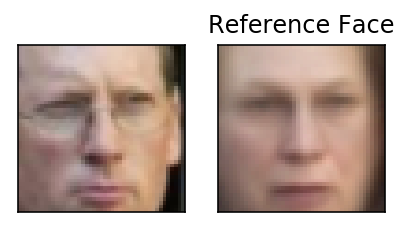

In [179]:
for x, _ in val_loader:
    input = Variable(x[0].cuda(GPU_IDX))
    reconstruction_mu, mu, logsigma = vae(input)
    reconstruction_mu = reconstruction_mu[0][0]
    break

plot_gallery([input.view(image_w, image_h, 3).data.cpu().numpy(),
              reconstruction_mu.view(image_w, image_h, 3).data.cpu().numpy()],
             image_h, image_w, n_row=1, n_col=2)
plt.title('Reference Face');

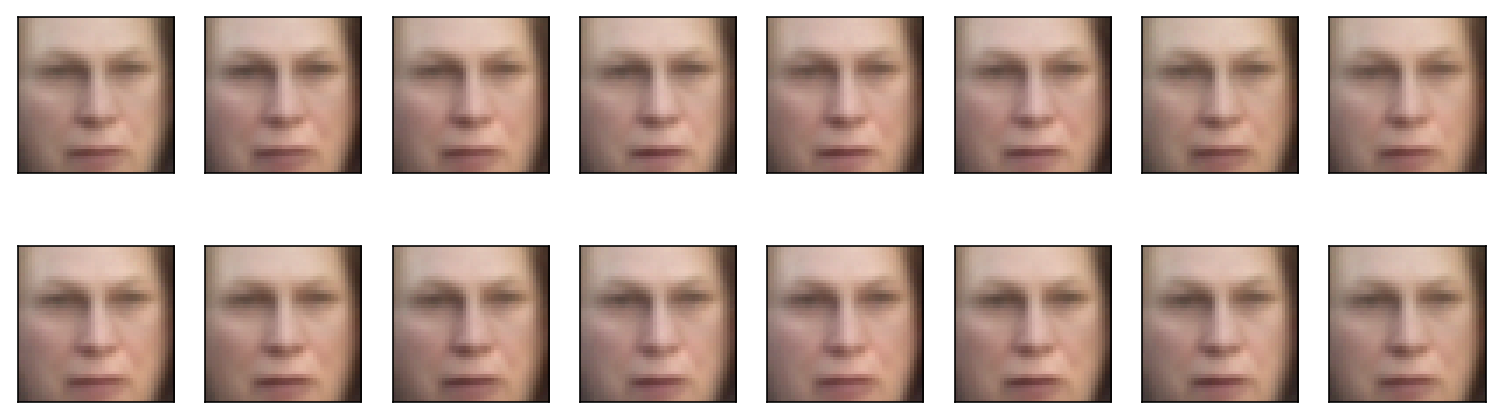

In [180]:
# Let's sample images from the distribution given x from validation
z_s = [sample_from_latent(mu, logsigma) for _ in range(16)]
images = [get_image_from_latent(vae, z) for z in z_s]
plot_gallery(images, image_h, image_w, n_row=2, n_col=len(images) // 2)

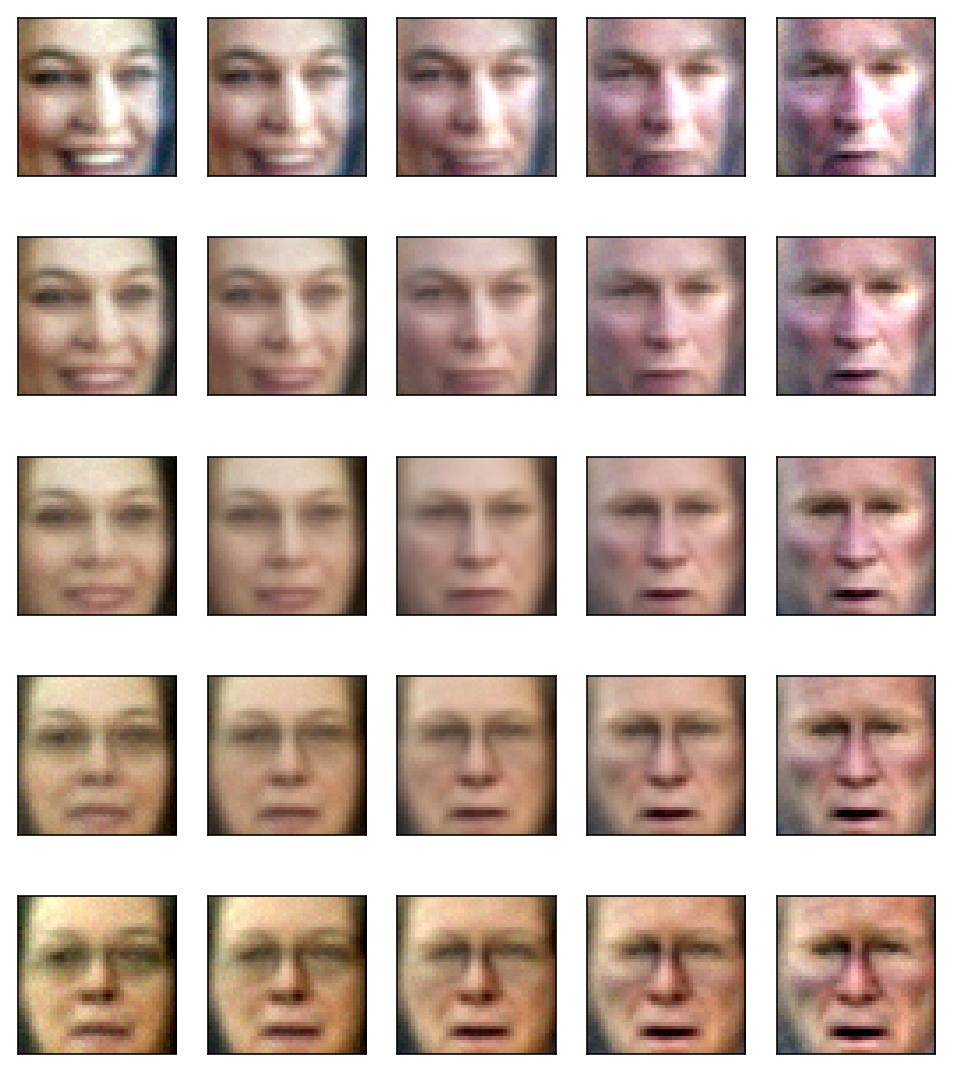

In [194]:
coordinate_x = 45 # 0 to hidden_size-1
coordinate_y = 33 # 0 to hidden_size-1
images = [get_image_from_latent(vae, mu + get_unit_vector(hidden_size, coordinate_x) * loc_x
                                        + get_unit_vector(hidden_size, coordinate_y) * loc_y)
          for loc_x, loc_y in it.product(np.linspace(-5, 5, num=5), np.linspace(-5, 5, num=5))]
plot_gallery(images, image_h, image_w, n_row=5, n_col=5)